In [1]:
import pandas as pd
import numpy as np
import os
import glob
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow

# from tensorflow.compat.v1.keras.backend import get_session
# tensorflow.compat.v1.disable_v2_behavior()
# import shap

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from sklearn import preprocessing

import tensorflow as tf

import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Only using years 2010, 2011, 2012, 2013, and 2014 because of the auroral boundary database used only has those dates

In [2]:
file_load_df_cumulative = '../ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.sort_values(by=['ID_SC', 'Datetimes'])
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)

# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])

mask_for_2010_to_2014 = [(df_train.index.year == 2010) | (df_train.index.year == 2011)
                         | (df_train.index.year == 2012) |(df_train.index.year == 2013)
                         | (df_train.index.year == 2014)]
df_train = df_train[mask_for_2010_to_2014[0]]
df_train = df_train.sort_values(by=['ID_SC', 'Datetimes'])
df_val = df_val.sort_values(by=['ID_SC', 'Datetimes'])

In [3]:
# Construct X and y
feature_cols = [c for c in df_train.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
from sklearn import preprocessing
X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

%matplotlib inline  
import matplotlib.pyplot as plt
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

# First train without considering the auroral regions at all to get a baseline MSE accuracy

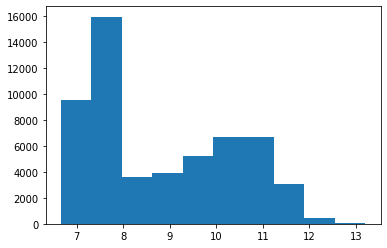

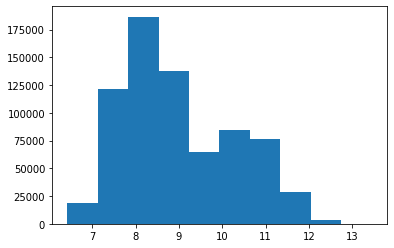

In [4]:
plt.figure()
# summarize history for loss
plt.hist(y_val_log.values)
plt.show()

plt.figure()
# summarize history for loss
plt.hist(y_train_log.values)
plt.show()

In [5]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)),
                    batch_size=1024,epochs=1000)

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][200:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/1000
705/705 [==============================] - 1s 2ms/step - loss: 9.9167 - mse: 9.9167 - val_loss: 1.9905 - val_mse: 1.9905
Epoch 2/1000
705/705 [==============================] - 1s 2ms/step - loss: 2.1877 - mse: 2.1877 - val_loss: 1.6850 - val_mse: 1.6850
Epoch 3/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.3537 - mse: 1.3537 - val_loss: 1.2690 - val_mse: 1.2690
Epoch 4/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.0260 - mse: 1.0260 - val_loss: 1.0903 - val_mse: 1.0903
Epoch 5/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.9285 - mse: 0.9285 - val_loss: 1.0016 - val_mse: 1.0016
Epoch 6/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.8384 - mse: 0.8384 - val_loss: 0.8897 - val_mse: 0.8897
Epoch 7/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.7398 - mse: 0.7398 - val_loss: 0.7536 - val_mse: 0.7536
Epoch 8/1000
705/705 [==============================] - 1s 2ms

Epoch 62/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4852 - mse: 0.4852 - val_loss: 0.6001 - val_mse: 0.6001
Epoch 63/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4838 - mse: 0.4838 - val_loss: 0.5989 - val_mse: 0.5989
Epoch 64/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4855 - mse: 0.4855 - val_loss: 0.5960 - val_mse: 0.5960
Epoch 65/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4842 - mse: 0.4842 - val_loss: 0.6042 - val_mse: 0.6042
Epoch 66/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4825 - mse: 0.4825 - val_loss: 0.6028 - val_mse: 0.6028
Epoch 67/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4827 - mse: 0.4827 - val_loss: 0.6012 - val_mse: 0.6012
Epoch 68/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4816 - mse: 0.4816 - val_loss: 0.5941 - val_mse: 0.5941
Epoch 69/1000
705/705 [==============================] 

705/705 [==============================] - 1s 2ms/step - loss: 0.4658 - mse: 0.4658 - val_loss: 0.5931 - val_mse: 0.5931
Epoch 123/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4657 - mse: 0.4657 - val_loss: 0.5991 - val_mse: 0.5991
Epoch 124/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4638 - mse: 0.4638 - val_loss: 0.5922 - val_mse: 0.5922
Epoch 125/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4637 - mse: 0.4637 - val_loss: 0.5997 - val_mse: 0.5997
Epoch 126/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4636 - mse: 0.4636 - val_loss: 0.6023 - val_mse: 0.6023
Epoch 127/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4667 - mse: 0.4667 - val_loss: 0.6037 - val_mse: 0.6037
Epoch 128/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4636 - mse: 0.4636 - val_loss: 0.5972 - val_mse: 0.5972
Epoch 129/1000
705/705 [==============================] - 1s 2m

KeyboardInterrupt: 

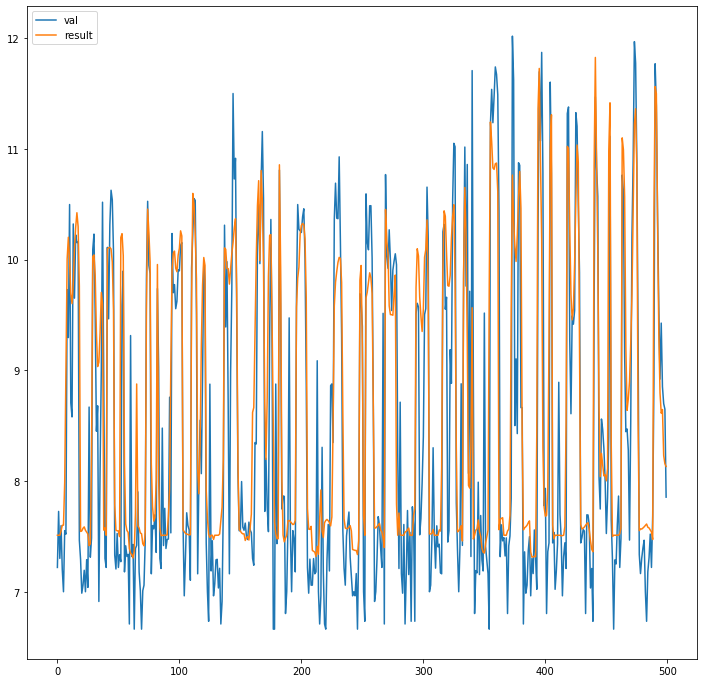

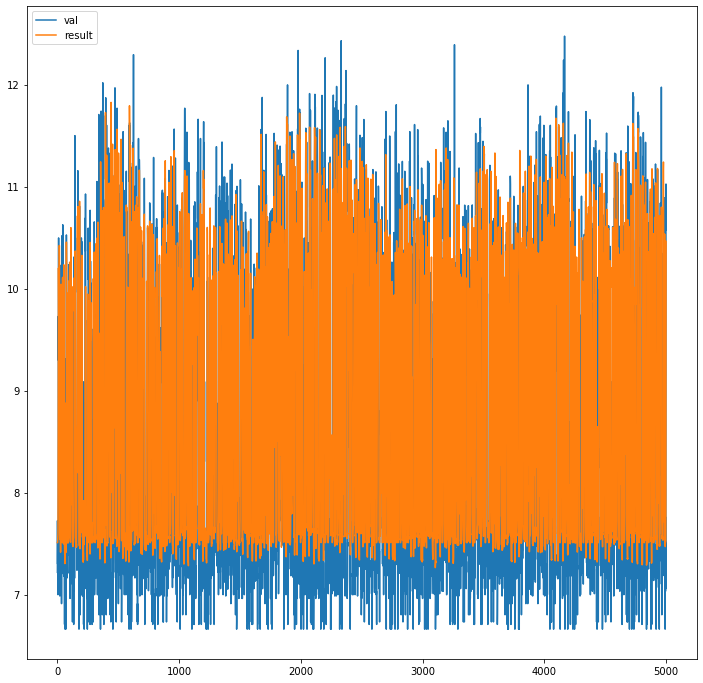

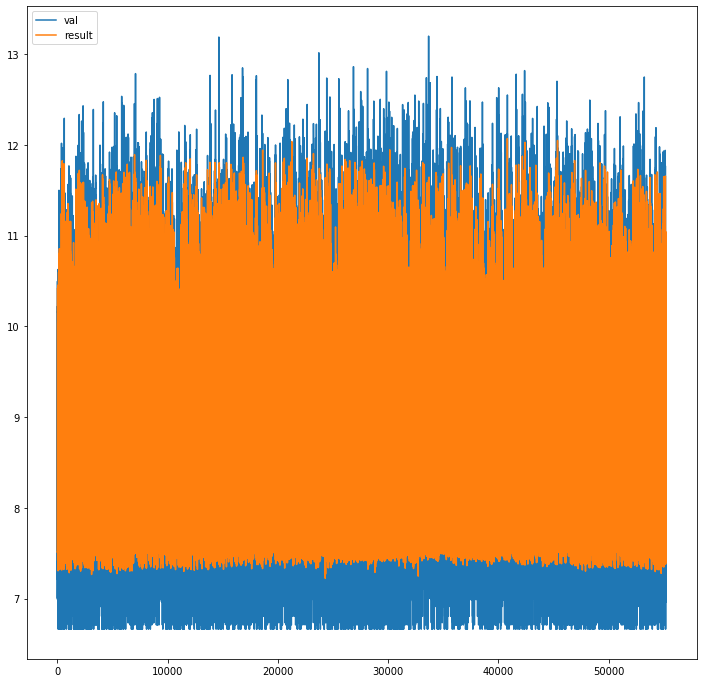

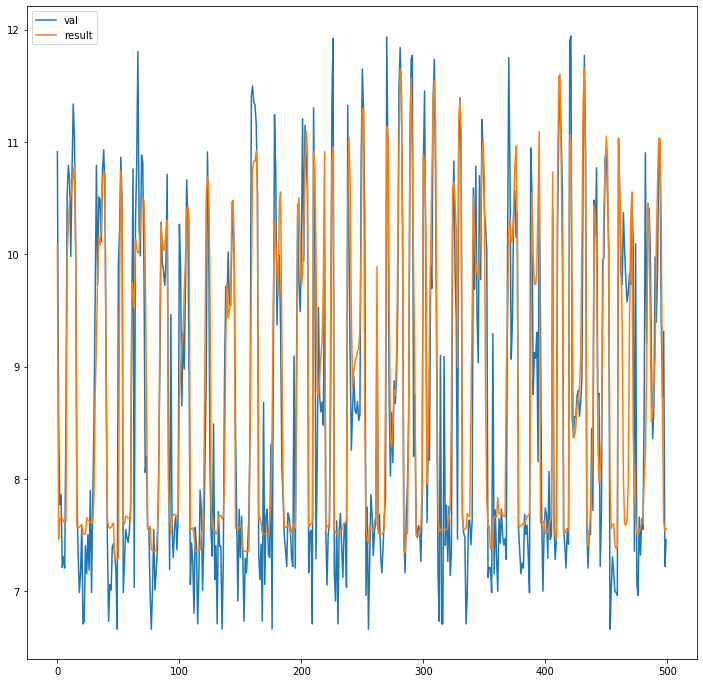

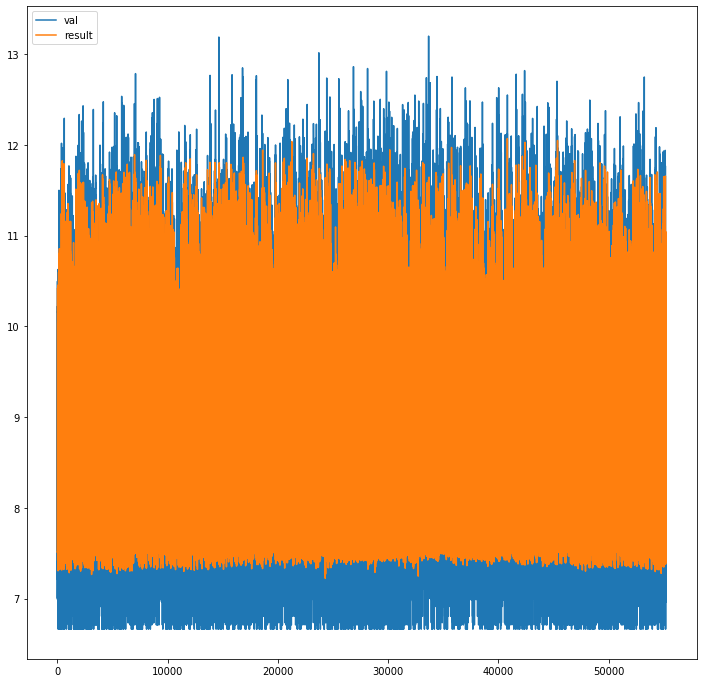

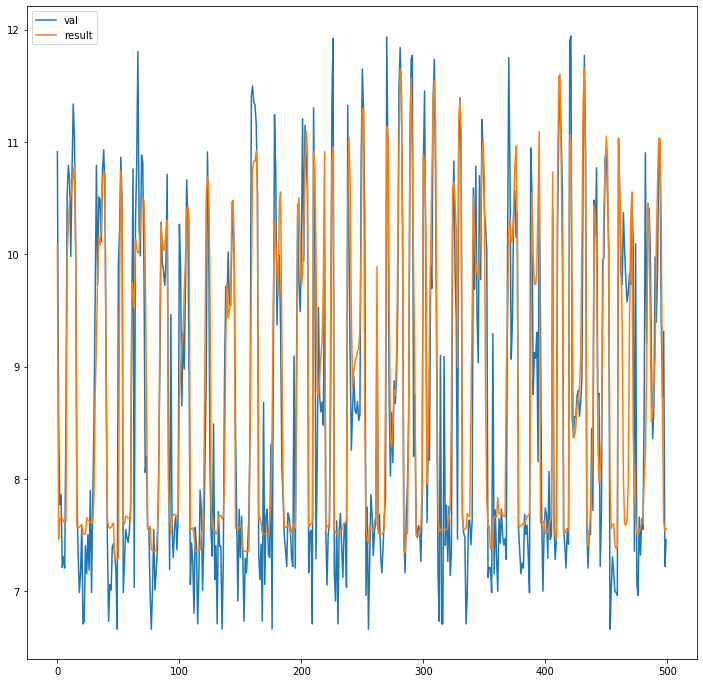

In [6]:

filename = 'best_base_line'

# model.save(filename)
model = tensorflow.keras.models.load_model(filename)

results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)


plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:5000])
plt.plot(results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

# Read in the the auroral regions from a pickle file (constructed from auroral boundary transition points) 

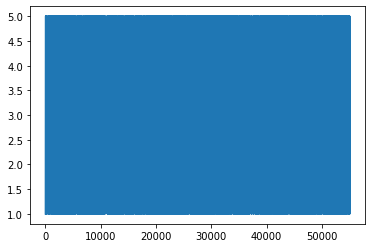

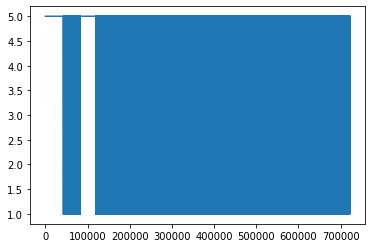

In [48]:
# df_val.to_pickle('with_aurora_type_val.pkl')
# df_train.to_pickle('with_aurora_type_train.pkl')
df_val = pd.read_pickle("./with_aurora_type_val.pkl")
df_train = pd.read_pickle("./with_aurora_type_train.pkl")


plt.figure()
plt.plot(df_val['aurora_type'].values[:])
plt.show()

plt.figure()
plt.plot(df_train['aurora_type'].values[:])
plt.show()

In [49]:
sum(df_val['aurora_type']==5)/df_val['aurora_type'].shape[0]

0.564933888788263

In [50]:
sum(df_train['aurora_type']==5)/df_train['aurora_type'].shape[0]

0.5490338676186004

# The boundary transition type regions can be reduced to 3 instead of 4 regions (plus unknown region 5), because going into the auroal region from the equatorial region or the polar region is the same for our intention of labeling just equatorial region, auroral, region, or polar region. 

# therefore type 4 is the same as type 1

In [51]:
df_val['aurora_type'][ df_val['aurora_type']==4 ]= 1
df_train['aurora_type'][ df_train['aurora_type']==4 ]= 1

print('equatorial', sum(df_train['aurora_type']==2)/df_train['aurora_type'].shape[0])
print('auroral', sum(df_train['aurora_type']==1)/df_train['aurora_type'].shape[0])
print('polar', sum(df_train['aurora_type']==3)/df_train['aurora_type'].shape[0])
print('unknown', sum(df_val['aurora_type']==5)/df_val['aurora_type'].shape[0])

equatorial 0.22883672092633456
auroral 0.10463513594006918
polar 0.11624617848203142
unknown 0.564933888788263


False
False
False


(array([ 7048.,     0., 10174.,     0.,     0.,  6626.,     0.,     0.,
            0., 31190.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

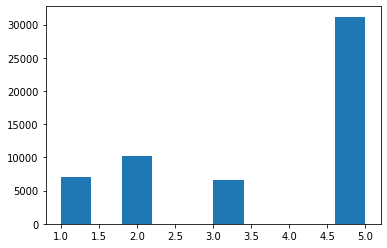

In [52]:

mask = ( np.isnan(df_train['aurora_type'])==False )
df_train_clean = df_train[mask].copy(deep=True)
print((mask.any())==False)
mask = ( np.isnan(df_val['aurora_type'])==False)
df_val_clean = df_val[mask].copy(deep=True)

print(np.isnan(df_val_clean).any().any())
print(np.isnan(df_train_clean).any().any())



plt.hist(df_val_clean['aurora_type'])

In [53]:

# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
from sklearn import preprocessing
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

%matplotlib inline  
import matplotlib.pyplot as plt
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)


In [54]:
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

In [55]:

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)

print(X_train_no_aurora_type_scaled.shape)

print(y_train_aurora_type.shape)
print(y_train_aurora_type_encoded.shape)

(720998,)
(720998,)
(720998, 148)
(720998,)
(720998, 4)


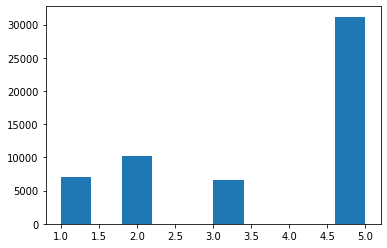

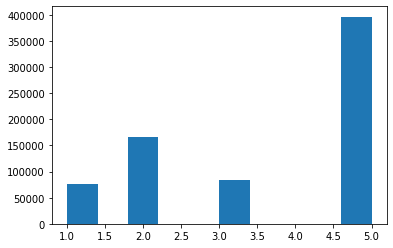

In [56]:
plt.hist(y_val_aurora_type)
plt.show()
plt.hist(y_train_aurora_type)
plt.show()

False
(23848, 148)
(324651,)
(324651,)
(324651, 148)
(324651,)
(324651, 3)
equatorial 0.22883672092633456
auroral 0.10463513594006918
polar 0.11624617848203142


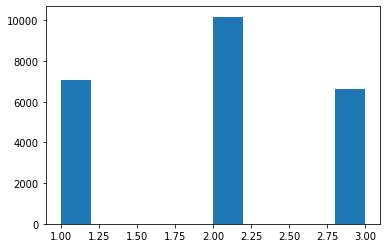

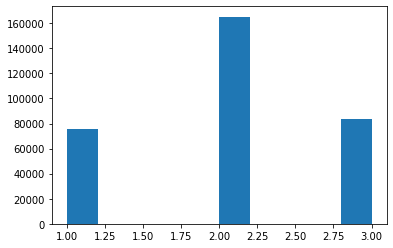

In [57]:

mask = [ (np.isnan(df_train['aurora_type'])==False) & (df_train['aurora_type'] != 5 ) ]
df_train_clean = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==False) & (df_val['aurora_type'] != 5 ) ]
df_val_clean = df_val[mask[0]].copy(deep=True)



# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
from sklearn import preprocessing
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))


X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)

X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
print(X_val_no_aurora_type_scaled.shape)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)

print(X_train_no_aurora_type_scaled.shape)

print(y_train_aurora_type.shape)
print(y_train_aurora_type_encoded.shape)

sum(df_val_clean['aurora_type']==2)/df_val_clean.shape[0]
sum(df_train_clean['aurora_type']==2)/df_train_clean.shape[0]

print('equatorial', sum(df_train['aurora_type']==2)/df_train['aurora_type'].shape[0])
print('auroral', sum(df_train['aurora_type']==1)/df_train['aurora_type'].shape[0])
print('polar', sum(df_train['aurora_type']==3)/df_train['aurora_type'].shape[0])

plt.hist(y_val_aurora_type)
plt.show()
plt.hist(y_train_aurora_type)
plt.show()

In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3,activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',  metrics=['accuracy'])

history = model.fit(X_train_no_aurora_type_scaled, y_train_aurora_type_encoded, validation_data=(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded), batch_size=32,epochs=75)

In [ ]:
# filename = 'best_auroral_region_predictor'

# # model = tensorflow.keras.models.load_model(filename)
# model.save(filename)
# model.save_weights('best_auroral_region_predictor_weights.h5')

746/746 [==============================] - 1s 1ms/step - loss: 0.1872 - accuracy: 0.9190


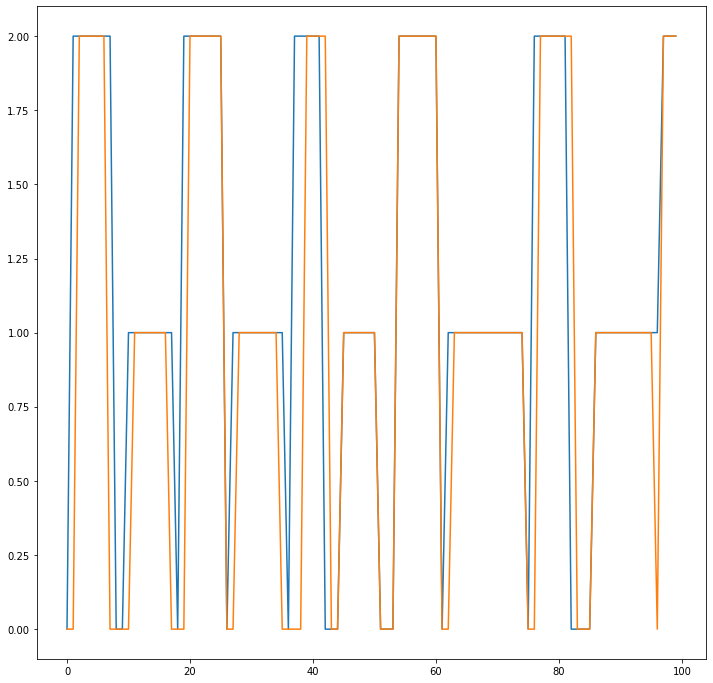

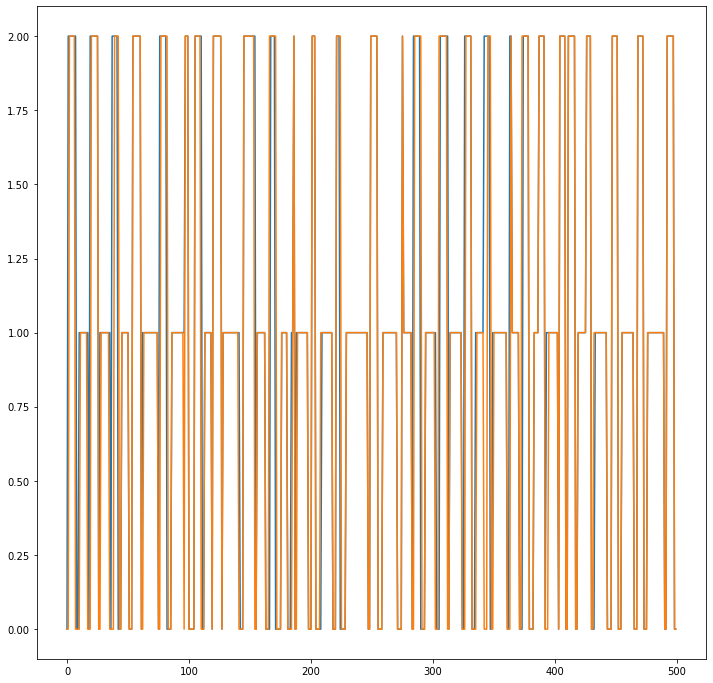

In [58]:
filename = 'best_auroral_region_predictor'

model = tensorflow.keras.models.load_model(filename)
# model.save(filename)
# model.save_weights('best_auroral_region_predictor_weights.h5')

model.evaluate(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded)

results = (model.predict_classes(X_val_no_aurora_type_scaled))#, y_val_log.values)#, batch_size=128)



# plt.figure(figsize=(12,12))

# plt.plot( integer_encoded_val[:3000])
# plt.plot(results[:3000])
# plt.show()
plt.figure(figsize=(12,12))

plt.plot( integer_encoded_val[:100])
plt.plot(results[:100])
plt.show()

plt.figure(figsize=(12,12))

plt.plot( integer_encoded_val[:500])
plt.plot(results[:500])
plt.show()

# Now use this Auroal region predictor model to predict what type the "unknown/unspecified" regions are.  Then combine this predicted data with the known training and test data

In [75]:
 
mask = [ (np.isnan(df_train['aurora_type'])==True) | (df_train['aurora_type'] == 5 ) ]
df_train_pred = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==True) | (df_val['aurora_type'] == 5 ) ]
df_val_pred = df_val[mask[0]].copy(deep=True)
print(df_train_pred.shape)
print(df_val_pred.shape)

False
(397248, 150)
(31362, 150)


In [76]:
print(df_train_pred.columns)

# Construct X and y
feature_cols = [c for c in df_train_pred.columns if (not ( 'ELE' in c) | ('aurora_type' in c))]
X_train = df_train_pred[feature_cols].copy(deep=True)
X_val = df_val_pred[feature_cols].copy(deep=True)
print(X_train.shape)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)
#scaler_X = scaler_X.fit(X_train_no_aurora_type.values)



Index(['SC_AACGM_LAT', 'ELE_TOTAL_ENERGY_FLUX', 'ID_SC', 'sin_ut', 'cos_ut',
       'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME',
       'F107',
       ...
       'AL_5min', 'AU_5min', 'SymH_5min', 'PC_5min', 'vsw_5min', 'vx_5min',
       'psw_5min', 'borovsky_5min', 'newell_5min', 'aurora_type'],
      dtype='object', length=150)
(397248, 148)


(397248, 148)
(324651,)
(397248, 150)
(397248, 150)
(324651, 150)
(55210, 150)


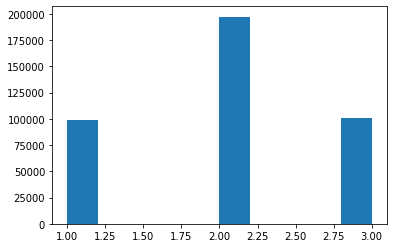

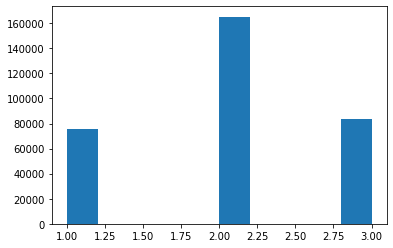

In [77]:

print(X.shape)

print((model.predict_classes(X_train_no_aurora_type_scaled)).shape)
print(df_train_pred.shape)

df_train_pred['aurora_type']= model.predict_classes(X)+1
df_val_pred['aurora_type']= model.predict_classes(X_test)+1

plt.figure()
plt.hist(df_train_pred['aurora_type'])
plt.figure()
plt.hist(df_train_clean['aurora_type'])

print(df_train_pred.shape)
print(df_train_clean.shape)

frames = [df_train_clean, df_train_pred]
df_train_new = pd.concat(frames)
frames = [df_val_clean, df_val_pred]
df_val_new = pd.concat(frames) 

print(df_val_new.values.shape)

In [78]:

# Construct X and y
feature_cols = [c for c in df_train_new.columns if not 'ELE' in c]

X_val = df_val_new[feature_cols].copy(deep=True)
y_val = df_val_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
y_train = df_train_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)


(array([174354.,      0.,      0.,      0.,      0., 362529.,      0.,
             0.,      0., 185016.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

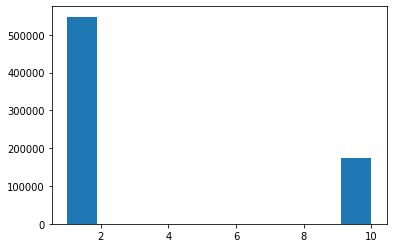

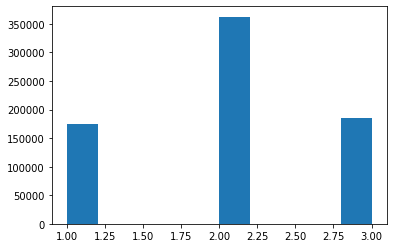

In [63]:
sample_weights = np.ones((X_train.values.shape[0]))
for i in range(0,X_train.values.shape[0]):
    if X_train['aurora_type'].values[i]==1:
        sample_weights[i]=10

plt.figure()
plt.hist(sample_weights)
plt.figure()
plt.hist(X_train['aurora_type'].values)

# Now with the supervised auroral type values and the predicted (unsupervised) type values as a new column in the input X, predict the scalar energy flux y

In [32]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])

history = model.fit(X, np.array(y_train_log), 
    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000, sample_weight=sample_weights)

Epoch 1/1000
705/705 [==============================] - 1s 2ms/step - loss: 32.2589 - mse: 9.0179 - mae: 1.8742 - val_loss: 1.8361 - val_mse: 1.8361 - val_mae: 1.0740
Epoch 2/1000
705/705 [==============================] - 1s 2ms/step - loss: 6.7899 - mse: 2.0038 - mae: 1.0997 - val_loss: 1.4560 - val_mse: 1.4560 - val_mae: 0.9612
Epoch 3/1000
705/705 [==============================] - 1s 2ms/step - loss: 4.3132 - mse: 1.2396 - mae: 0.8594 - val_loss: 1.2271 - val_mse: 1.2271 - val_mae: 0.8900
Epoch 4/1000
705/705 [==============================] - 1s 2ms/step - loss: 3.5727 - mse: 0.9977 - mae: 0.7729 - val_loss: 1.0110 - val_mse: 1.0110 - val_mae: 0.8049
Epoch 5/1000
705/705 [==============================] - 1s 2ms/step - loss: 3.1722 - mse: 0.9173 - mae: 0.7405 - val_loss: 0.9019 - val_mse: 0.9019 - val_mae: 0.7557
Epoch 6/1000
705/705 [==============================] - 1s 2ms/step - loss: 2.9018 - mse: 0.8679 - mae: 0.7201 - val_loss: 0.8823 - val_mse: 0.8823 - val_mae: 0.7405
Epo

705/705 [==============================] - 1s 2ms/step - loss: 1.7219 - mse: 0.5116 - mae: 0.5198 - val_loss: 0.5993 - val_mse: 0.5993 - val_mae: 0.5600
Epoch 51/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.7114 - mse: 0.5079 - mae: 0.5181 - val_loss: 0.5961 - val_mse: 0.5961 - val_mae: 0.5549
Epoch 52/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.7134 - mse: 0.5074 - mae: 0.5175 - val_loss: 0.6090 - val_mse: 0.6090 - val_mae: 0.5652
Epoch 53/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.7094 - mse: 0.5074 - mae: 0.5174 - val_loss: 0.6008 - val_mse: 0.6008 - val_mae: 0.5556
Epoch 54/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.7090 - mse: 0.5069 - mae: 0.5169 - val_loss: 0.6002 - val_mse: 0.6002 - val_mae: 0.5561
Epoch 55/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.7011 - mse: 0.5035 - mae: 0.5151 - val_loss: 0.6005 - val_mse: 0.6005 - val_mae: 0.5580
Epoch 56/100

705/705 [==============================] - 1s 2ms/step - loss: 1.6276 - mse: 0.4856 - mae: 0.5020 - val_loss: 0.5893 - val_mse: 0.5893 - val_mae: 0.5563
Epoch 100/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.6263 - mse: 0.4844 - mae: 0.5014 - val_loss: 0.5903 - val_mse: 0.5903 - val_mae: 0.5554
Epoch 101/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.6274 - mse: 0.4855 - mae: 0.5016 - val_loss: 0.5906 - val_mse: 0.5906 - val_mae: 0.5538
Epoch 102/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.6303 - mse: 0.4861 - mae: 0.5019 - val_loss: 0.5977 - val_mse: 0.5977 - val_mae: 0.5568
Epoch 103/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.6236 - mse: 0.4848 - mae: 0.5012 - val_loss: 0.5896 - val_mse: 0.5896 - val_mae: 0.5614
Epoch 104/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.6194 - mse: 0.4827 - mae: 0.4998 - val_loss: 0.6001 - val_mse: 0.6001 - val_mae: 0.5590
Epoch 1

Epoch 148/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5811 - mse: 0.4742 - mae: 0.4945 - val_loss: 0.5933 - val_mse: 0.5933 - val_mae: 0.5549
Epoch 149/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5826 - mse: 0.4754 - mae: 0.4954 - val_loss: 0.5888 - val_mse: 0.5888 - val_mae: 0.5481
Epoch 150/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5804 - mse: 0.4744 - mae: 0.4950 - val_loss: 0.5912 - val_mse: 0.5912 - val_mae: 0.5534
Epoch 151/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5759 - mse: 0.4739 - mae: 0.4945 - val_loss: 0.5883 - val_mse: 0.5883 - val_mae: 0.5488
Epoch 152/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5750 - mse: 0.4733 - mae: 0.4941 - val_loss: 0.5951 - val_mse: 0.5951 - val_mae: 0.5561
Epoch 153/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5751 - mse: 0.4732 - mae: 0.4939 - val_loss: 0.5944 - val_mse: 0.5944 - val_mae:

Epoch 197/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5488 - mse: 0.4679 - mae: 0.4909 - val_loss: 0.5900 - val_mse: 0.5900 - val_mae: 0.5580
Epoch 198/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5463 - mse: 0.4688 - mae: 0.4915 - val_loss: 0.5973 - val_mse: 0.5973 - val_mae: 0.5534
Epoch 199/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5441 - mse: 0.4682 - mae: 0.4909 - val_loss: 0.5925 - val_mse: 0.5925 - val_mae: 0.5516
Epoch 200/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5460 - mse: 0.4678 - mae: 0.4907 - val_loss: 0.5932 - val_mse: 0.5932 - val_mae: 0.5554
Epoch 201/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5478 - mse: 0.4682 - mae: 0.4910 - val_loss: 0.5909 - val_mse: 0.5909 - val_mae: 0.5577
Epoch 202/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5437 - mse: 0.4673 - mae: 0.4902 - val_loss: 0.5873 - val_mse: 0.5873 - val_mae:

Epoch 246/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5277 - mse: 0.4642 - mae: 0.4881 - val_loss: 0.5911 - val_mse: 0.5911 - val_mae: 0.5493
Epoch 247/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5263 - mse: 0.4646 - mae: 0.4886 - val_loss: 0.5953 - val_mse: 0.5953 - val_mae: 0.5573
Epoch 248/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5258 - mse: 0.4639 - mae: 0.4880 - val_loss: 0.5907 - val_mse: 0.5907 - val_mae: 0.5568
Epoch 249/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5231 - mse: 0.4633 - mae: 0.4876 - val_loss: 0.5942 - val_mse: 0.5942 - val_mae: 0.5535
Epoch 250/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5254 - mse: 0.4643 - mae: 0.4882 - val_loss: 0.5899 - val_mse: 0.5899 - val_mae: 0.5531
Epoch 251/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5226 - mse: 0.4641 - mae: 0.4880 - val_loss: 0.5960 - val_mse: 0.5960 - val_mae:

Epoch 295/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5069 - mse: 0.4607 - mae: 0.4863 - val_loss: 0.5892 - val_mse: 0.5892 - val_mae: 0.5502
Epoch 296/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5071 - mse: 0.4611 - mae: 0.4865 - val_loss: 0.5869 - val_mse: 0.5869 - val_mae: 0.5550
Epoch 297/1000
705/705 [==============================] - 2s 2ms/step - loss: 1.5094 - mse: 0.4607 - mae: 0.4860 - val_loss: 0.5884 - val_mse: 0.5884 - val_mae: 0.5528
Epoch 298/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5011 - mse: 0.4601 - mae: 0.4860 - val_loss: 0.5932 - val_mse: 0.5932 - val_mae: 0.5582
Epoch 299/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5136 - mse: 0.4617 - mae: 0.4868 - val_loss: 0.5900 - val_mse: 0.5900 - val_mae: 0.5588
Epoch 300/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5072 - mse: 0.4617 - mae: 0.4867 - val_loss: 0.5958 - val_mse: 0.5958 - val_mae:

Epoch 344/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4954 - mse: 0.4594 - mae: 0.4854 - val_loss: 0.5922 - val_mse: 0.5922 - val_mae: 0.5514
Epoch 345/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4926 - mse: 0.4590 - mae: 0.4851 - val_loss: 0.5971 - val_mse: 0.5971 - val_mae: 0.5506
Epoch 346/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4883 - mse: 0.4582 - mae: 0.4846 - val_loss: 0.5883 - val_mse: 0.5883 - val_mae: 0.5547
Epoch 347/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4936 - mse: 0.4582 - mae: 0.4843 - val_loss: 0.5968 - val_mse: 0.5968 - val_mae: 0.5516
Epoch 348/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4897 - mse: 0.4579 - mae: 0.4845 - val_loss: 0.5920 - val_mse: 0.5920 - val_mae: 0.5639
Epoch 349/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4939 - mse: 0.4585 - mae: 0.4847 - val_loss: 0.5957 - val_mse: 0.5957 - val_mae:

Epoch 393/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4849 - mse: 0.4562 - mae: 0.4833 - val_loss: 0.5901 - val_mse: 0.5901 - val_mae: 0.5574
Epoch 394/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4824 - mse: 0.4560 - mae: 0.4833 - val_loss: 0.5903 - val_mse: 0.5903 - val_mae: 0.5580
Epoch 395/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4864 - mse: 0.4578 - mae: 0.4843 - val_loss: 0.5909 - val_mse: 0.5909 - val_mae: 0.5562
Epoch 396/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4807 - mse: 0.4565 - mae: 0.4833 - val_loss: 0.5849 - val_mse: 0.5849 - val_mae: 0.5496
Epoch 397/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4775 - mse: 0.4559 - mae: 0.4832 - val_loss: 0.5898 - val_mse: 0.5898 - val_mae: 0.5452
Epoch 398/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4865 - mse: 0.4570 - mae: 0.4840 - val_loss: 0.5904 - val_mse: 0.5904 - val_mae:

Epoch 442/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4738 - mse: 0.4547 - mae: 0.4824 - val_loss: 0.5913 - val_mse: 0.5913 - val_mae: 0.5502
Epoch 443/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4732 - mse: 0.4558 - mae: 0.4829 - val_loss: 0.5912 - val_mse: 0.5912 - val_mae: 0.5579
Epoch 444/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4709 - mse: 0.4549 - mae: 0.4825 - val_loss: 0.5922 - val_mse: 0.5922 - val_mae: 0.5514
Epoch 445/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4705 - mse: 0.4545 - mae: 0.4824 - val_loss: 0.5957 - val_mse: 0.5957 - val_mae: 0.5580
Epoch 446/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4733 - mse: 0.4549 - mae: 0.4824 - val_loss: 0.5910 - val_mse: 0.5910 - val_mae: 0.5574
Epoch 447/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4714 - mse: 0.4549 - mae: 0.4827 - val_loss: 0.5967 - val_mse: 0.5967 - val_mae:

Epoch 491/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4624 - mse: 0.4537 - mae: 0.4818 - val_loss: 0.5880 - val_mse: 0.5880 - val_mae: 0.5548
Epoch 492/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4600 - mse: 0.4531 - mae: 0.4813 - val_loss: 0.5892 - val_mse: 0.5892 - val_mae: 0.5552
Epoch 493/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4662 - mse: 0.4543 - mae: 0.4819 - val_loss: 0.5904 - val_mse: 0.5904 - val_mae: 0.5540
Epoch 494/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4650 - mse: 0.4538 - mae: 0.4818 - val_loss: 0.5887 - val_mse: 0.5887 - val_mae: 0.5540
Epoch 495/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4653 - mse: 0.4534 - mae: 0.4818 - val_loss: 0.5927 - val_mse: 0.5927 - val_mae: 0.5568
Epoch 496/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4627 - mse: 0.4532 - mae: 0.4816 - val_loss: 0.5909 - val_mse: 0.5909 - val_mae:

705/705 [==============================] - 1s 2ms/step - loss: 1.4549 - mse: 0.4520 - mae: 0.4807 - val_loss: 0.5905 - val_mse: 0.5905 - val_mae: 0.5519
Epoch 540/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4644 - mse: 0.4547 - mae: 0.4820 - val_loss: 0.5918 - val_mse: 0.5918 - val_mae: 0.5500
Epoch 541/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4568 - mse: 0.4523 - mae: 0.4809 - val_loss: 0.5982 - val_mse: 0.5982 - val_mae: 0.5627
Epoch 542/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4547 - mse: 0.4525 - mae: 0.4811 - val_loss: 0.5923 - val_mse: 0.5923 - val_mae: 0.5499
Epoch 543/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4570 - mse: 0.4532 - mae: 0.4812 - val_loss: 0.5935 - val_mse: 0.5935 - val_mae: 0.5548
Epoch 544/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4550 - mse: 0.4527 - mae: 0.4809 - val_loss: 0.5890 - val_mse: 0.5890 - val_mae: 0.5487
Epoch 5

Epoch 588/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4535 - mse: 0.4519 - mae: 0.4805 - val_loss: 0.6006 - val_mse: 0.6006 - val_mae: 0.5480
Epoch 589/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4505 - mse: 0.4518 - mae: 0.4803 - val_loss: 0.5920 - val_mse: 0.5920 - val_mae: 0.5553
Epoch 590/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4543 - mse: 0.4516 - mae: 0.4806 - val_loss: 0.5938 - val_mse: 0.5938 - val_mae: 0.5608
Epoch 591/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4547 - mse: 0.4523 - mae: 0.4806 - val_loss: 0.5902 - val_mse: 0.5902 - val_mae: 0.5535
Epoch 592/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4464 - mse: 0.4508 - mae: 0.4798 - val_loss: 0.5981 - val_mse: 0.5981 - val_mae: 0.5567
Epoch 593/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4484 - mse: 0.4513 - mae: 0.4799 - val_loss: 0.5943 - val_mse: 0.5943 - val_mae:

Epoch 637/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4413 - mse: 0.4498 - mae: 0.4788 - val_loss: 0.5892 - val_mse: 0.5892 - val_mae: 0.5515
Epoch 638/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4473 - mse: 0.4516 - mae: 0.4803 - val_loss: 0.5886 - val_mse: 0.5886 - val_mae: 0.5505
Epoch 639/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4405 - mse: 0.4501 - mae: 0.4793 - val_loss: 0.5885 - val_mse: 0.5885 - val_mae: 0.5491
Epoch 640/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4418 - mse: 0.4495 - mae: 0.4791 - val_loss: 0.5913 - val_mse: 0.5913 - val_mae: 0.5540
Epoch 641/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4449 - mse: 0.4499 - mae: 0.4796 - val_loss: 0.5894 - val_mse: 0.5894 - val_mae: 0.5480
Epoch 642/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4424 - mse: 0.4499 - mae: 0.4797 - val_loss: 0.5899 - val_mse: 0.5899 - val_mae:

Epoch 686/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4383 - mse: 0.4487 - mae: 0.4782 - val_loss: 0.5986 - val_mse: 0.5986 - val_mae: 0.5544
Epoch 687/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4370 - mse: 0.4487 - mae: 0.4783 - val_loss: 0.5953 - val_mse: 0.5953 - val_mae: 0.5610
Epoch 688/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4384 - mse: 0.4490 - mae: 0.4786 - val_loss: 0.5952 - val_mse: 0.5952 - val_mae: 0.5609
Epoch 689/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4373 - mse: 0.4488 - mae: 0.4786 - val_loss: 0.5942 - val_mse: 0.5942 - val_mae: 0.5622
Epoch 690/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4439 - mse: 0.4505 - mae: 0.4799 - val_loss: 0.5905 - val_mse: 0.5905 - val_mae: 0.5507
Epoch 691/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4348 - mse: 0.4488 - mae: 0.4786 - val_loss: 0.5942 - val_mse: 0.5942 - val_mae:

Epoch 735/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4349 - mse: 0.4486 - mae: 0.4784 - val_loss: 0.5919 - val_mse: 0.5919 - val_mae: 0.5509
Epoch 736/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4309 - mse: 0.4484 - mae: 0.4783 - val_loss: 0.5927 - val_mse: 0.5927 - val_mae: 0.5489
Epoch 737/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4301 - mse: 0.4477 - mae: 0.4781 - val_loss: 0.5915 - val_mse: 0.5915 - val_mae: 0.5539
Epoch 738/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4306 - mse: 0.4476 - mae: 0.4779 - val_loss: 0.5910 - val_mse: 0.5910 - val_mae: 0.5521
Epoch 739/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4324 - mse: 0.4484 - mae: 0.4779 - val_loss: 0.5947 - val_mse: 0.5947 - val_mae: 0.5575
Epoch 740/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4307 - mse: 0.4478 - mae: 0.4778 - val_loss: 0.5867 - val_mse: 0.5867 - val_mae:

Epoch 784/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4284 - mse: 0.4473 - mae: 0.4776 - val_loss: 0.5956 - val_mse: 0.5956 - val_mae: 0.5546
Epoch 785/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4331 - mse: 0.4493 - mae: 0.4788 - val_loss: 0.5894 - val_mse: 0.5894 - val_mae: 0.5493
Epoch 786/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4292 - mse: 0.4482 - mae: 0.4782 - val_loss: 0.5910 - val_mse: 0.5910 - val_mae: 0.5493
Epoch 787/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4215 - mse: 0.4466 - mae: 0.4770 - val_loss: 0.5918 - val_mse: 0.5918 - val_mae: 0.5576
Epoch 788/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4290 - mse: 0.4476 - mae: 0.4778 - val_loss: 0.5948 - val_mse: 0.5948 - val_mae: 0.5506
Epoch 789/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4215 - mse: 0.4472 - mae: 0.4775 - val_loss: 0.5914 - val_mse: 0.5914 - val_mae:

Epoch 833/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4250 - mse: 0.4473 - mae: 0.4776 - val_loss: 0.5935 - val_mse: 0.5935 - val_mae: 0.5504
Epoch 834/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4275 - mse: 0.4465 - mae: 0.4773 - val_loss: 0.5897 - val_mse: 0.5897 - val_mae: 0.5515
Epoch 835/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4256 - mse: 0.4472 - mae: 0.4776 - val_loss: 0.5910 - val_mse: 0.5910 - val_mae: 0.5548
Epoch 836/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4228 - mse: 0.4474 - mae: 0.4773 - val_loss: 0.5895 - val_mse: 0.5895 - val_mae: 0.5485
Epoch 837/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4233 - mse: 0.4461 - mae: 0.4769 - val_loss: 0.5905 - val_mse: 0.5905 - val_mae: 0.5546
Epoch 838/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4224 - mse: 0.4464 - mae: 0.4772 - val_loss: 0.5917 - val_mse: 0.5917 - val_mae:

Epoch 882/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4169 - mse: 0.4457 - mae: 0.4769 - val_loss: 0.5948 - val_mse: 0.5948 - val_mae: 0.5562
Epoch 883/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4245 - mse: 0.4466 - mae: 0.4773 - val_loss: 0.5904 - val_mse: 0.5904 - val_mae: 0.5494
Epoch 884/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4163 - mse: 0.4467 - mae: 0.4773 - val_loss: 0.5925 - val_mse: 0.5925 - val_mae: 0.5535
Epoch 885/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4217 - mse: 0.4475 - mae: 0.4773 - val_loss: 0.5868 - val_mse: 0.5868 - val_mae: 0.5469
Epoch 886/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4102 - mse: 0.4450 - mae: 0.4761 - val_loss: 0.5943 - val_mse: 0.5943 - val_mae: 0.5593
Epoch 887/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4168 - mse: 0.4454 - mae: 0.4766 - val_loss: 0.5919 - val_mse: 0.5919 - val_mae:

Epoch 931/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4149 - mse: 0.4456 - mae: 0.4764 - val_loss: 0.5940 - val_mse: 0.5940 - val_mae: 0.5510
Epoch 932/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4141 - mse: 0.4448 - mae: 0.4762 - val_loss: 0.5947 - val_mse: 0.5947 - val_mae: 0.5512
Epoch 933/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4182 - mse: 0.4460 - mae: 0.4765 - val_loss: 0.5894 - val_mse: 0.5894 - val_mae: 0.5472
Epoch 934/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4207 - mse: 0.4496 - mae: 0.4766 - val_loss: 0.6001 - val_mse: 0.6001 - val_mae: 0.5566
Epoch 935/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4171 - mse: 0.4460 - mae: 0.4770 - val_loss: 0.5910 - val_mse: 0.5910 - val_mae: 0.5532
Epoch 936/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4125 - mse: 0.4452 - mae: 0.4762 - val_loss: 0.5909 - val_mse: 0.5909 - val_mae:

Epoch 980/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4052 - mse: 0.4437 - mae: 0.4752 - val_loss: 0.5908 - val_mse: 0.5908 - val_mae: 0.5497
Epoch 981/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4098 - mse: 0.4445 - mae: 0.4757 - val_loss: 0.5934 - val_mse: 0.5934 - val_mae: 0.5563
Epoch 982/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4133 - mse: 0.4453 - mae: 0.4764 - val_loss: 0.5922 - val_mse: 0.5922 - val_mae: 0.5513
Epoch 983/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4098 - mse: 0.4442 - mae: 0.4757 - val_loss: 0.5927 - val_mse: 0.5927 - val_mae: 0.5522
Epoch 984/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4100 - mse: 0.4443 - mae: 0.4756 - val_loss: 0.5877 - val_mse: 0.5877 - val_mae: 0.5497
Epoch 985/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.4130 - mse: 0.4446 - mae: 0.4757 - val_loss: 0.5941 - val_mse: 0.5941 - val_mae:

W0717 16:39:30.980926 139935199254336 deprecation.py:506] From /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


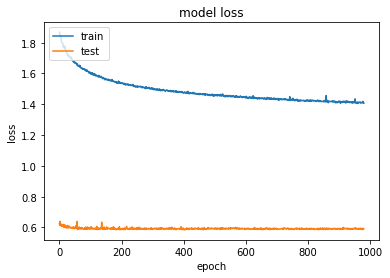

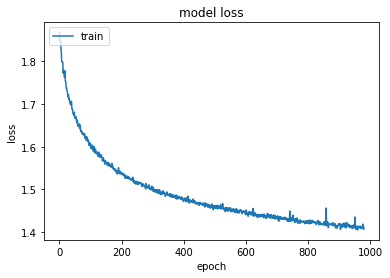

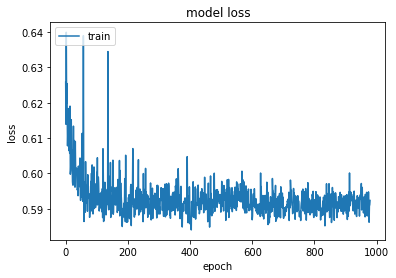

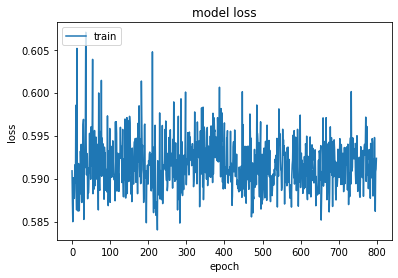

In [33]:
filename = 'best_with_auroral_region_weights'

model.save(filename)

model = tensorflow.keras.models.load_model(filename)
#model.save_weights('my_model_weights.h5')


print(history.history.keys())
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][200:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
model.evaluate(X_val_scaled,y_val_log)


1726/1726 [==============================] - 2s 938us/step - loss: 0.5924 - mean_squared_error: 0.5924 - mean_absolute_error: 0.5501


[0.592354953289032, 0.592354953289032, 0.5500954389572144]

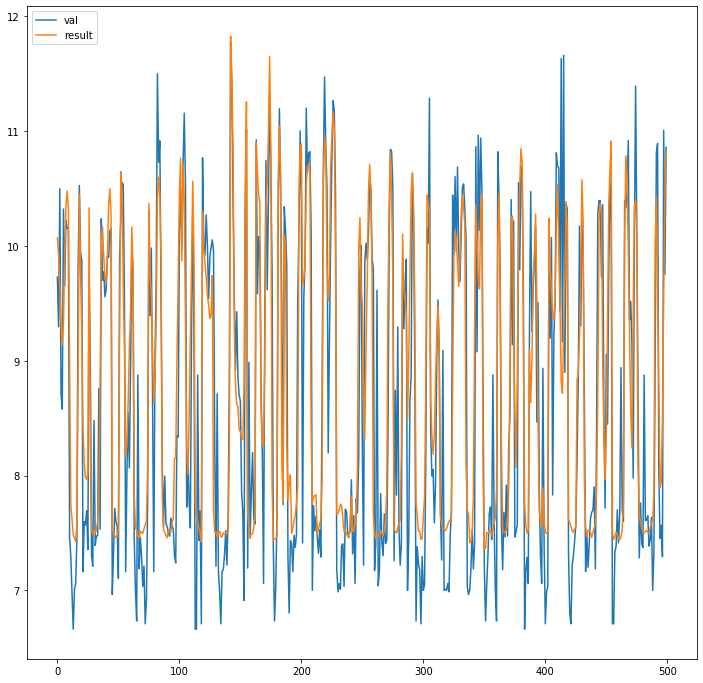

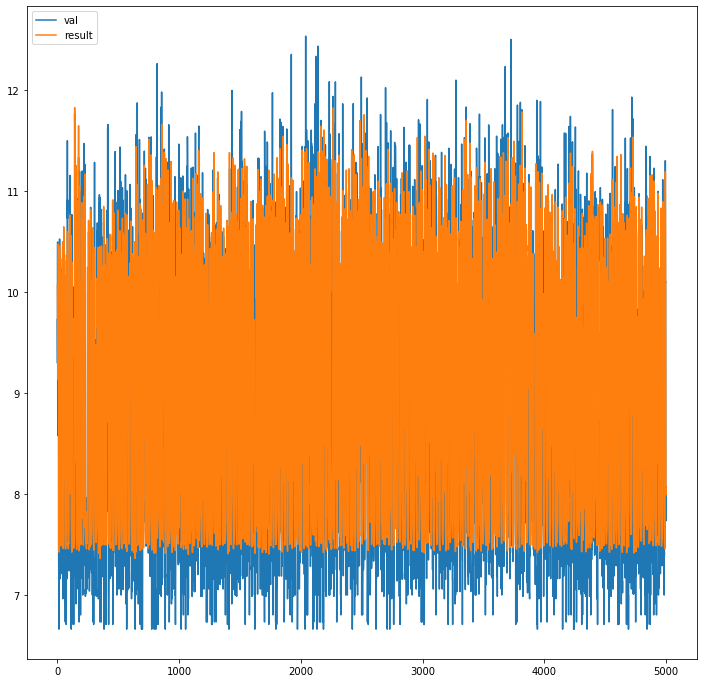

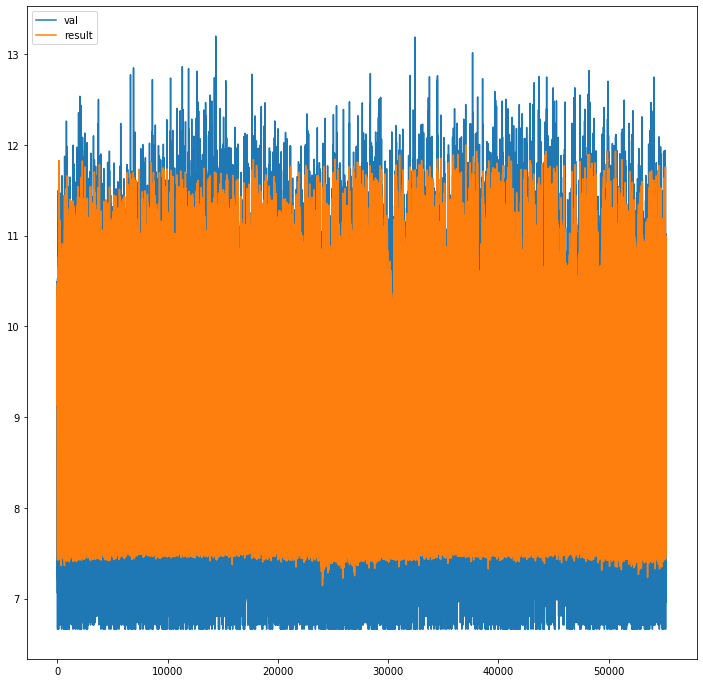

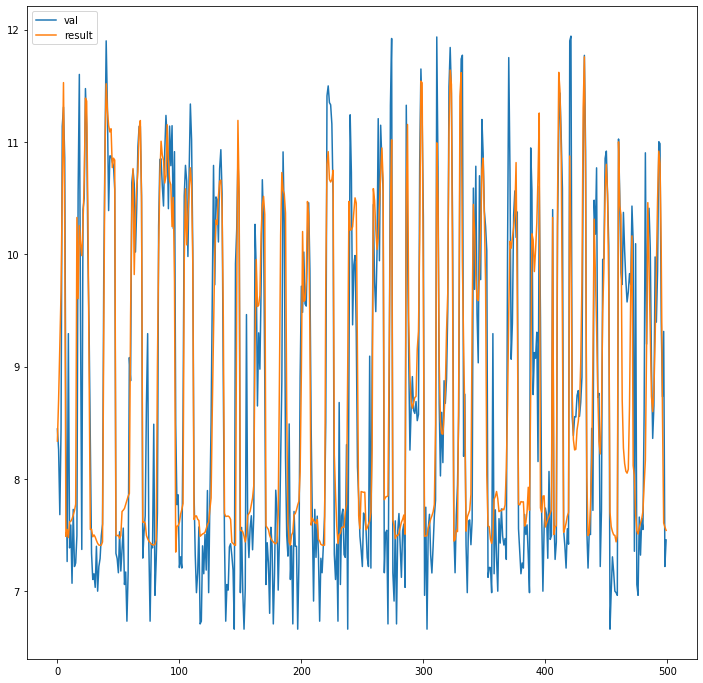

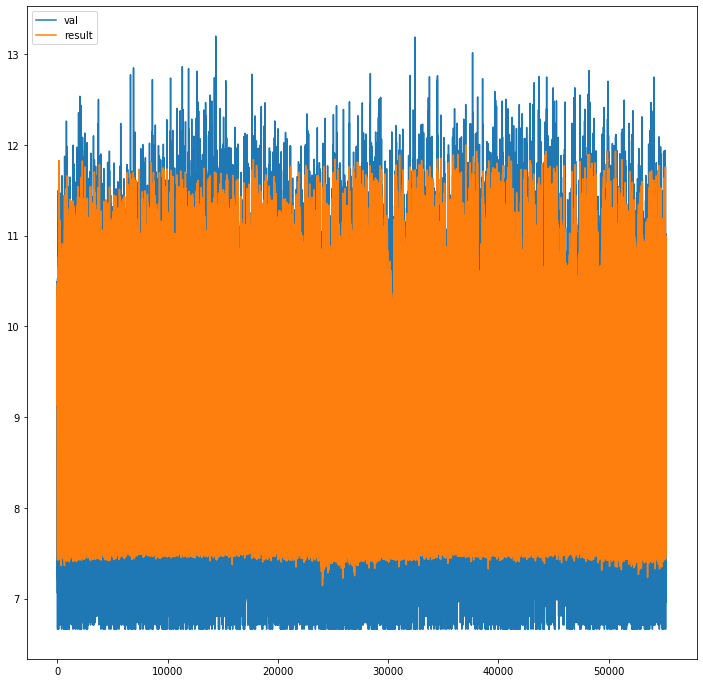

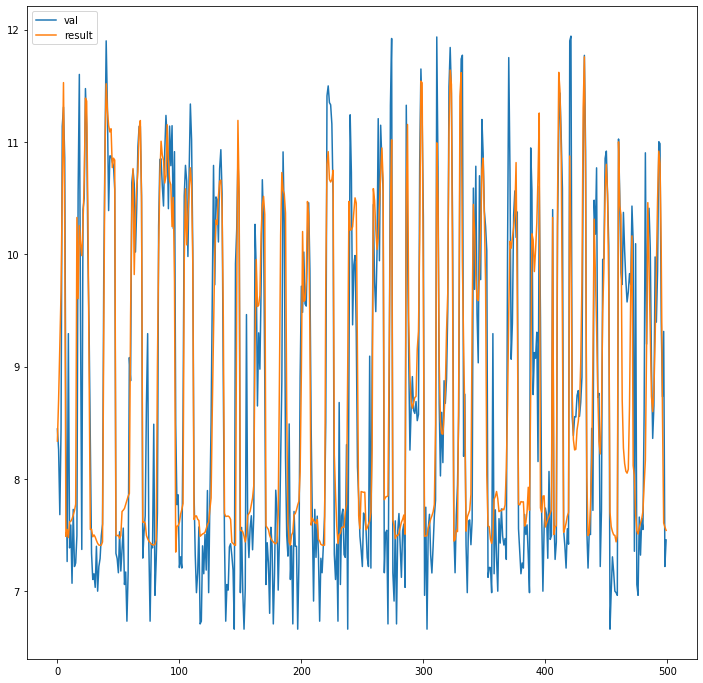

In [35]:
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)


plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:5000])
plt.plot(results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

# Now with the supervised auroral type values and the predicted (unsupervised) type values as a new column in the input X, predict the scalar energy flux y

# The target Y is now a vector result where the true value only has one of the three as non-zero, the correct answer is specified by the auroral region type, equatorial region, in aurora, and the polar region

# The loss is the MSE of all three, to compare this loss to the previous approach that is signal modal, multiply the loss by the number of modes which is three

(array([174354.,      0.,      0.,      0.,      0., 362529.,      0.,
             0.,      0., 185016.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

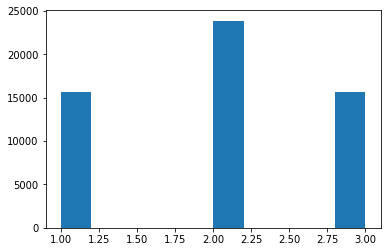

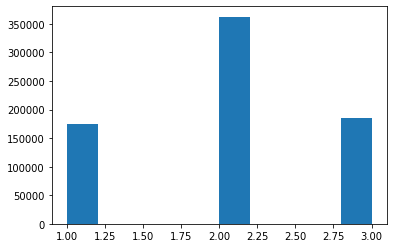

In [79]:

# Construct X and y
feature_cols = [c for c in df_train_new.columns if not 'ELE' in c]
X_val = df_val_new[feature_cols].copy(deep=True)
y_val = df_val_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
y_train_val = df_train_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log1 = np.log10(y_train.copy(deep=True))
y_val_log1 = np.log10(y_val.copy(deep=True))

y_train_log = np.zeros((y_train_log1.values.shape[0],3))
y_val_log = np.zeros((y_val_log1.values.shape[0],3))

for i in range(0,X_val.values.shape[0]):
    if X_val['aurora_type'].values[i] == 1:
        y_val_log[i,0]=y_val_log1.values[i]
    if X_val['aurora_type'].values[i] == 2:
        y_val_log[i,1]=y_val_log1.values[i]
    if X_val['aurora_type'].values[i] == 3:
        y_val_log[i,2]=y_val_log1.values[i]
for i in range(0,X_train.values.shape[0]):
    if X_train['aurora_type'].values[i] == 1:
        y_train_log[i,0]=y_train_log1.values[i]
    if X_train['aurora_type'].values[i] == 2:
        y_train_log[i,1]=y_train_log1.values[i]
    if X_train['aurora_type'].values[i] == 3:
        y_train_log[i,2]=y_train_log1.values[i]



scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

plt.figure()
plt.hist(X_val['aurora_type'].values)
plt.figure()
plt.hist(X_train['aurora_type'].values)

In [37]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), 
                    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000, sample_weight=sample_weights)

Epoch 1/1000
705/705 [==============================] - 1s 2ms/step - loss: 18.0363 - mse: 9.4300 - val_loss: 0.7974 - val_mse: 0.7974
Epoch 2/1000
705/705 [==============================] - 1s 2ms/step - loss: 2.7115 - mse: 1.0388 - val_loss: 0.3665 - val_mse: 0.3665
Epoch 3/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.5957 - mse: 0.5395 - val_loss: 0.2961 - val_mse: 0.2961
Epoch 4/1000
705/705 [==============================] - 1s 2ms/step - loss: 1.1975 - mse: 0.3920 - val_loss: 0.2776 - val_mse: 0.2776
Epoch 5/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.9999 - mse: 0.3274 - val_loss: 0.2567 - val_mse: 0.2567
Epoch 6/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.9181 - mse: 0.2924 - val_loss: 0.2501 - val_mse: 0.2501
Epoch 7/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.8751 - mse: 0.2734 - val_loss: 0.2405 - val_mse: 0.2405
Epoch 8/1000
705/705 [==============================] - 1s 2m

Epoch 62/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5984 - mse: 0.1785 - val_loss: 0.2068 - val_mse: 0.2068
Epoch 63/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.6038 - mse: 0.1816 - val_loss: 0.2050 - val_mse: 0.2050
Epoch 64/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5938 - mse: 0.1775 - val_loss: 0.2008 - val_mse: 0.2008
Epoch 65/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5957 - mse: 0.1787 - val_loss: 0.2040 - val_mse: 0.2040
Epoch 66/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.6043 - mse: 0.1829 - val_loss: 0.2028 - val_mse: 0.2028
Epoch 67/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5941 - mse: 0.1773 - val_loss: 0.2020 - val_mse: 0.2020
Epoch 68/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5915 - mse: 0.1765 - val_loss: 0.2032 - val_mse: 0.2032
Epoch 69/1000
705/705 [==============================] 

705/705 [==============================] - 1s 2ms/step - loss: 0.5611 - mse: 0.1683 - val_loss: 0.1993 - val_mse: 0.1993
Epoch 123/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5690 - mse: 0.1719 - val_loss: 0.2001 - val_mse: 0.2001
Epoch 124/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5625 - mse: 0.1689 - val_loss: 0.1972 - val_mse: 0.1972
Epoch 125/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5601 - mse: 0.1685 - val_loss: 0.1973 - val_mse: 0.1973
Epoch 126/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5599 - mse: 0.1675 - val_loss: 0.1993 - val_mse: 0.1993
Epoch 127/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5607 - mse: 0.1682 - val_loss: 0.1971 - val_mse: 0.1971
Epoch 128/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5600 - mse: 0.1674 - val_loss: 0.1975 - val_mse: 0.1975
Epoch 129/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5482 - mse: 0.1657 - val_loss: 0.1961 - val_mse: 0.1961
Epoch 183/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5457 - mse: 0.1647 - val_loss: 0.1976 - val_mse: 0.1976
Epoch 184/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5382 - mse: 0.1634 - val_loss: 0.1986 - val_mse: 0.1986
Epoch 185/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5443 - mse: 0.1647 - val_loss: 0.1995 - val_mse: 0.1995
Epoch 186/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5450 - mse: 0.1637 - val_loss: 0.1949 - val_mse: 0.1949
Epoch 187/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5432 - mse: 0.1638 - val_loss: 0.1948 - val_mse: 0.1948
Epoch 188/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5497 - mse: 0.1661 - val_loss: 0.1981 - val_mse: 0.1981
Epoch 189/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5399 - mse: 0.1630 - val_loss: 0.1953 - val_mse: 0.1953
Epoch 243/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5387 - mse: 0.1643 - val_loss: 0.1992 - val_mse: 0.1992
Epoch 244/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5336 - mse: 0.1619 - val_loss: 0.1972 - val_mse: 0.1972
Epoch 245/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5368 - mse: 0.1630 - val_loss: 0.1960 - val_mse: 0.1960
Epoch 246/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5379 - mse: 0.1636 - val_loss: 0.1967 - val_mse: 0.1967
Epoch 247/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5365 - mse: 0.1632 - val_loss: 0.1974 - val_mse: 0.1974
Epoch 248/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5378 - mse: 0.1643 - val_loss: 0.1973 - val_mse: 0.1973
Epoch 249/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5258 - mse: 0.1602 - val_loss: 0.1949 - val_mse: 0.1949
Epoch 303/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5252 - mse: 0.1599 - val_loss: 0.1964 - val_mse: 0.1964
Epoch 304/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5267 - mse: 0.1606 - val_loss: 0.1976 - val_mse: 0.1976
Epoch 305/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5266 - mse: 0.1605 - val_loss: 0.1976 - val_mse: 0.1976
Epoch 306/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5331 - mse: 0.1644 - val_loss: 0.1987 - val_mse: 0.1987
Epoch 307/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5311 - mse: 0.1618 - val_loss: 0.1982 - val_mse: 0.1982
Epoch 308/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5296 - mse: 0.1615 - val_loss: 0.1979 - val_mse: 0.1979
Epoch 309/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5243 - mse: 0.1607 - val_loss: 0.1965 - val_mse: 0.1965
Epoch 363/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5212 - mse: 0.1601 - val_loss: 0.1955 - val_mse: 0.1955
Epoch 364/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5227 - mse: 0.1601 - val_loss: 0.1982 - val_mse: 0.1982
Epoch 365/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5217 - mse: 0.1595 - val_loss: 0.1960 - val_mse: 0.1960
Epoch 366/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5216 - mse: 0.1597 - val_loss: 0.1970 - val_mse: 0.1970
Epoch 367/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5235 - mse: 0.1601 - val_loss: 0.1963 - val_mse: 0.1963
Epoch 368/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5210 - mse: 0.1590 - val_loss: 0.1979 - val_mse: 0.1979
Epoch 369/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5243 - mse: 0.1614 - val_loss: 0.1956 - val_mse: 0.1956
Epoch 423/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5223 - mse: 0.1612 - val_loss: 0.1960 - val_mse: 0.1960
Epoch 424/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5203 - mse: 0.1599 - val_loss: 0.1985 - val_mse: 0.1985
Epoch 425/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5192 - mse: 0.1588 - val_loss: 0.1992 - val_mse: 0.1992
Epoch 426/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5478 - mse: 0.1687 - val_loss: 0.2004 - val_mse: 0.2004
Epoch 427/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5181 - mse: 0.1594 - val_loss: 0.1989 - val_mse: 0.1989
Epoch 428/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5139 - mse: 0.1576 - val_loss: 0.1943 - val_mse: 0.1943
Epoch 429/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5208 - mse: 0.1600 - val_loss: 0.1986 - val_mse: 0.1986
Epoch 483/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5146 - mse: 0.1594 - val_loss: 0.1967 - val_mse: 0.1967
Epoch 484/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5137 - mse: 0.1582 - val_loss: 0.1980 - val_mse: 0.1980
Epoch 485/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5135 - mse: 0.1581 - val_loss: 0.1933 - val_mse: 0.1933
Epoch 486/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5131 - mse: 0.1579 - val_loss: 0.1971 - val_mse: 0.1971
Epoch 487/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5144 - mse: 0.1582 - val_loss: 0.1984 - val_mse: 0.1984
Epoch 488/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5185 - mse: 0.1594 - val_loss: 0.1945 - val_mse: 0.1945
Epoch 489/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5097 - mse: 0.1571 - val_loss: 0.1960 - val_mse: 0.1960
Epoch 543/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5119 - mse: 0.1577 - val_loss: 0.1954 - val_mse: 0.1954
Epoch 544/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5143 - mse: 0.1586 - val_loss: 0.1956 - val_mse: 0.1956
Epoch 545/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5125 - mse: 0.1577 - val_loss: 0.1963 - val_mse: 0.1963
Epoch 546/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5104 - mse: 0.1574 - val_loss: 0.1999 - val_mse: 0.1999
Epoch 547/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5123 - mse: 0.1573 - val_loss: 0.1971 - val_mse: 0.1971
Epoch 548/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5155 - mse: 0.1576 - val_loss: 0.1973 - val_mse: 0.1973
Epoch 549/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5064 - mse: 0.1565 - val_loss: 0.1967 - val_mse: 0.1967
Epoch 603/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5076 - mse: 0.1560 - val_loss: 0.1958 - val_mse: 0.1958
Epoch 604/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5067 - mse: 0.1561 - val_loss: 0.1960 - val_mse: 0.1960
Epoch 605/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5078 - mse: 0.1562 - val_loss: 0.1954 - val_mse: 0.1954
Epoch 606/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5094 - mse: 0.1569 - val_loss: 0.1958 - val_mse: 0.1958
Epoch 607/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5118 - mse: 0.1580 - val_loss: 0.1964 - val_mse: 0.1964
Epoch 608/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5115 - mse: 0.1572 - val_loss: 0.1968 - val_mse: 0.1968
Epoch 609/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5043 - mse: 0.1561 - val_loss: 0.1955 - val_mse: 0.1955
Epoch 663/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5034 - mse: 0.1554 - val_loss: 0.1959 - val_mse: 0.1959
Epoch 664/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5027 - mse: 0.1550 - val_loss: 0.1974 - val_mse: 0.1974
Epoch 665/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5025 - mse: 0.1556 - val_loss: 0.1974 - val_mse: 0.1974
Epoch 666/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5050 - mse: 0.1557 - val_loss: 0.1943 - val_mse: 0.1943
Epoch 667/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5079 - mse: 0.1563 - val_loss: 0.1954 - val_mse: 0.1954
Epoch 668/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5049 - mse: 0.1559 - val_loss: 0.1953 - val_mse: 0.1953
Epoch 669/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5063 - mse: 0.1566 - val_loss: 0.1965 - val_mse: 0.1965
Epoch 723/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5028 - mse: 0.1555 - val_loss: 0.1982 - val_mse: 0.1982
Epoch 724/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5077 - mse: 0.1574 - val_loss: 0.2020 - val_mse: 0.2020
Epoch 725/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5030 - mse: 0.1563 - val_loss: 0.1965 - val_mse: 0.1965
Epoch 726/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5053 - mse: 0.1558 - val_loss: 0.1989 - val_mse: 0.1989
Epoch 727/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5029 - mse: 0.1560 - val_loss: 0.1957 - val_mse: 0.1957
Epoch 728/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5039 - mse: 0.1554 - val_loss: 0.1969 - val_mse: 0.1969
Epoch 729/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.4980 - mse: 0.1544 - val_loss: 0.1973 - val_mse: 0.1973
Epoch 783/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.1547 - val_loss: 0.1971 - val_mse: 0.1971
Epoch 784/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4986 - mse: 0.1549 - val_loss: 0.1956 - val_mse: 0.1956
Epoch 785/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5115 - mse: 0.1627 - val_loss: 0.1965 - val_mse: 0.1965
Epoch 786/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5075 - mse: 0.1560 - val_loss: 0.1967 - val_mse: 0.1967
Epoch 787/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5006 - mse: 0.1547 - val_loss: 0.1950 - val_mse: 0.1950
Epoch 788/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4988 - mse: 0.1547 - val_loss: 0.1984 - val_mse: 0.1984
Epoch 789/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5024 - mse: 0.1553 - val_loss: 0.1998 - val_mse: 0.1998
Epoch 843/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4986 - mse: 0.1552 - val_loss: 0.1953 - val_mse: 0.1953
Epoch 844/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4985 - mse: 0.1546 - val_loss: 0.1992 - val_mse: 0.1992
Epoch 845/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4995 - mse: 0.1548 - val_loss: 0.1956 - val_mse: 0.1956
Epoch 846/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.1551 - val_loss: 0.1970 - val_mse: 0.1970
Epoch 847/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.1547 - val_loss: 0.1972 - val_mse: 0.1972
Epoch 848/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4996 - mse: 0.1545 - val_loss: 0.1954 - val_mse: 0.1954
Epoch 849/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.5001 - mse: 0.1546 - val_loss: 0.1975 - val_mse: 0.1975
Epoch 903/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5015 - mse: 0.1554 - val_loss: 0.1984 - val_mse: 0.1984
Epoch 904/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4986 - mse: 0.1553 - val_loss: 0.1966 - val_mse: 0.1966
Epoch 905/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4947 - mse: 0.1542 - val_loss: 0.1981 - val_mse: 0.1981
Epoch 906/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4956 - mse: 0.1542 - val_loss: 0.1952 - val_mse: 0.1952
Epoch 907/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4979 - mse: 0.1546 - val_loss: 0.1971 - val_mse: 0.1971
Epoch 908/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4962 - mse: 0.1549 - val_loss: 0.1974 - val_mse: 0.1974
Epoch 909/1000
705/705 [==============================] - 1s 2m

705/705 [==============================] - 1s 2ms/step - loss: 0.4972 - mse: 0.1551 - val_loss: 0.1970 - val_mse: 0.1970
Epoch 963/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4957 - mse: 0.1542 - val_loss: 0.1962 - val_mse: 0.1962
Epoch 964/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4958 - mse: 0.1539 - val_loss: 0.1961 - val_mse: 0.1961
Epoch 965/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4967 - mse: 0.1546 - val_loss: 0.2009 - val_mse: 0.2009
Epoch 966/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.4952 - mse: 0.1541 - val_loss: 0.1972 - val_mse: 0.1972
Epoch 967/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5002 - mse: 0.1549 - val_loss: 0.1964 - val_mse: 0.1964
Epoch 968/1000
705/705 [==============================] - 1s 2ms/step - loss: 0.5044 - mse: 0.1559 - val_loss: 0.2003 - val_mse: 0.2003
Epoch 969/1000
705/705 [==============================] - 1s 2m

In [38]:
filename = 'best_with_auroral_region4_weighted'

model.save(filename)
# model.save_weights('my_model_weights2.h5')

1726/1726 [==============================] - 1s 836us/step - loss: 0.1963 - mean_squared_error: 0.1963
dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


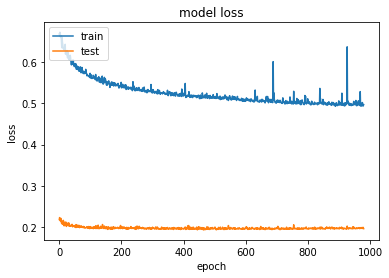

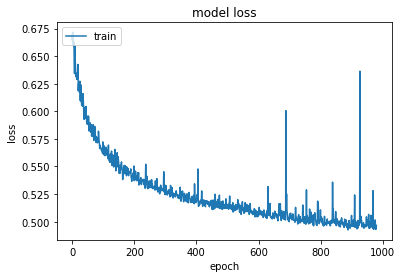

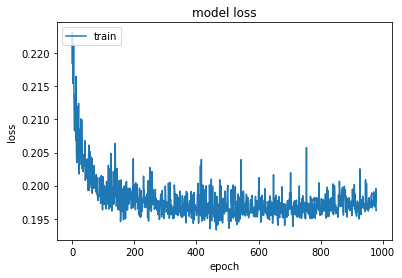

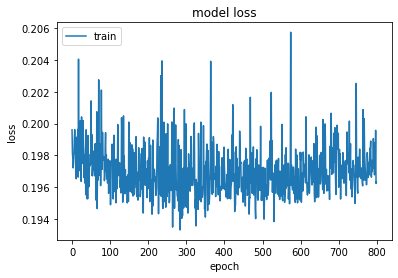

In [40]:
filename = 'best_with_auroral_region4_weighted'

model = tensorflow.keras.models.load_model(filename)

model.evaluate(X_val_scaled,np.array(y_val_log))


print(history.history.keys())
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][200:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

55210
(55210,)


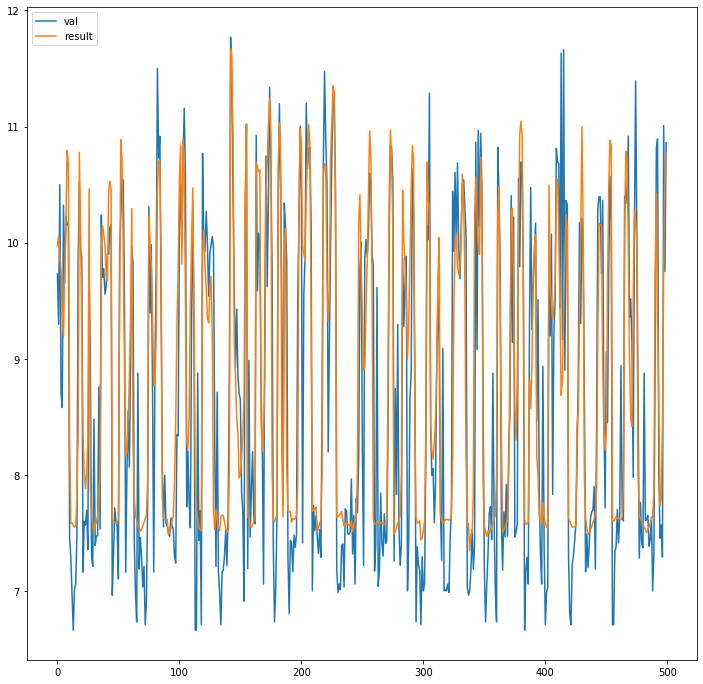

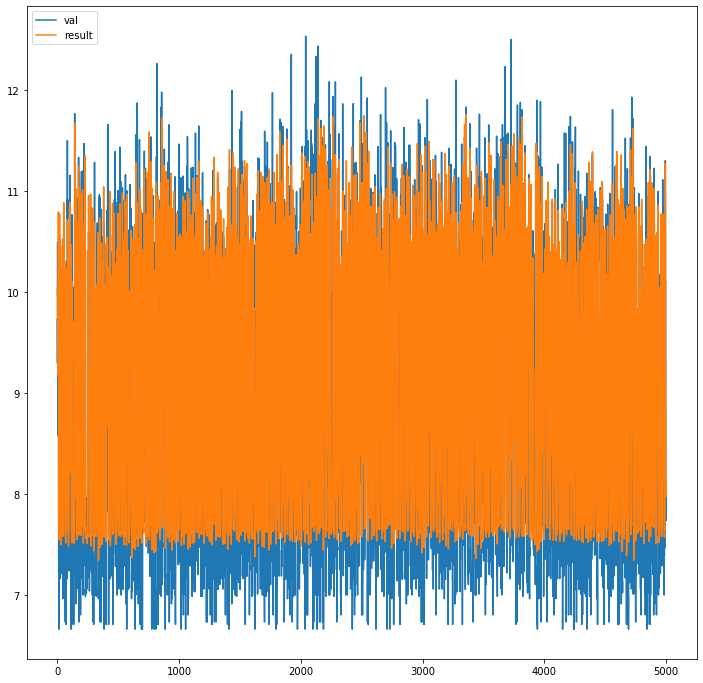

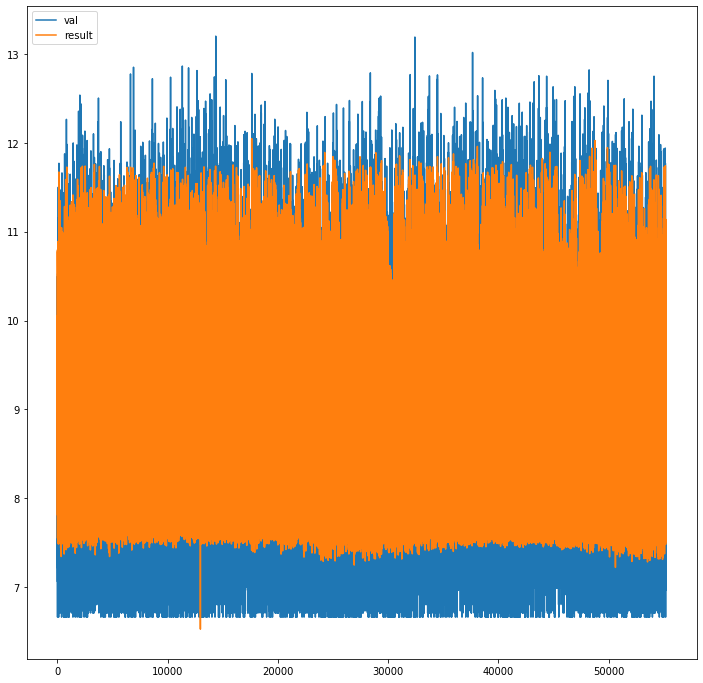

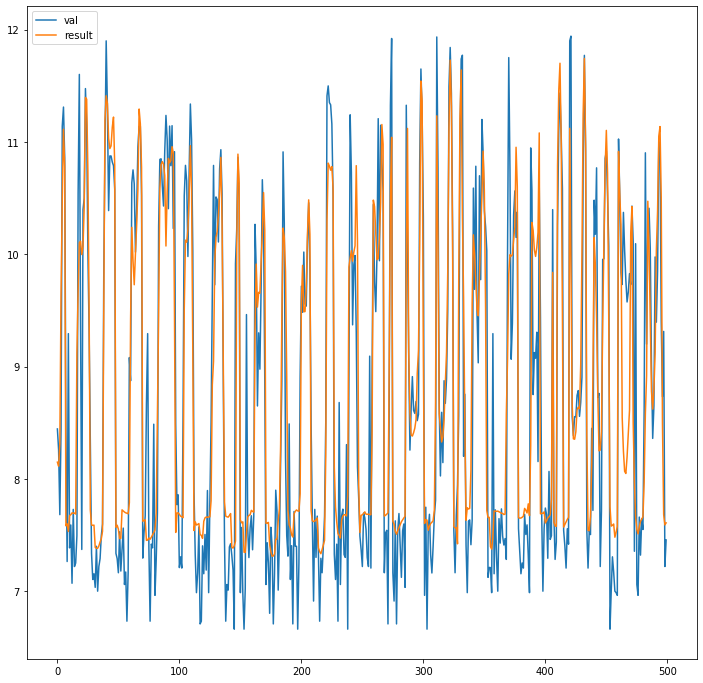

In [41]:
results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.max(results1[i,:])
    y[i] = np.max(y_val_log[i,:])
    
plt.figure(figsize=(12,12))
plt.plot(y[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[:5000])
plt.plot(results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

In [42]:
mse_final = np.average((results-y)**2)
print(mse_final)

0.587224906448618


55210
(55210,)


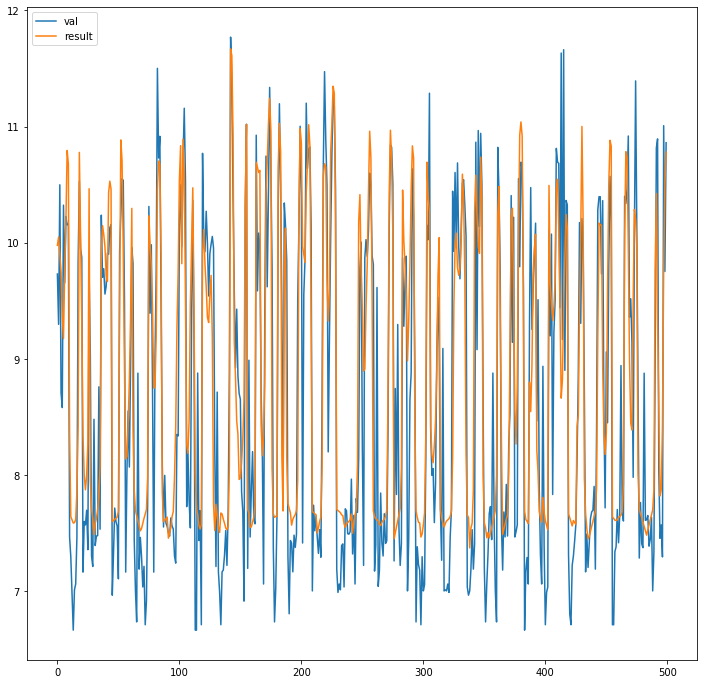

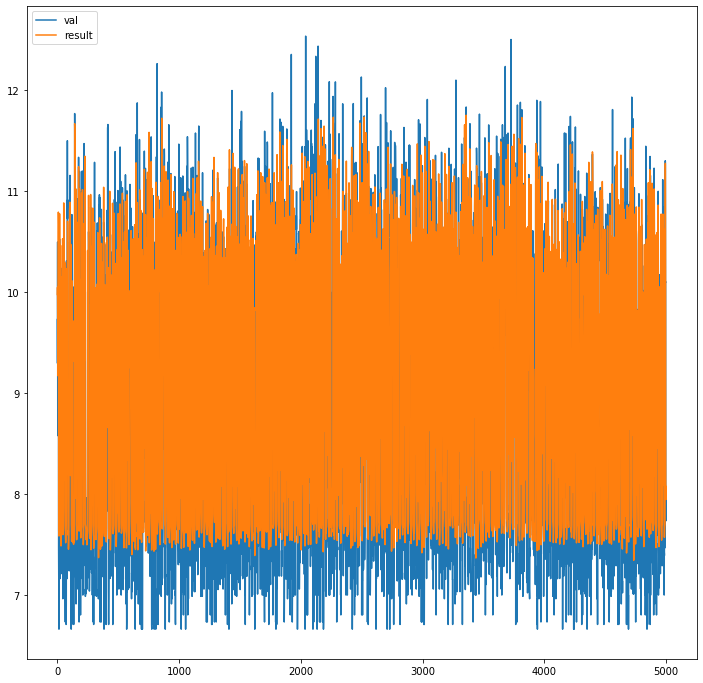

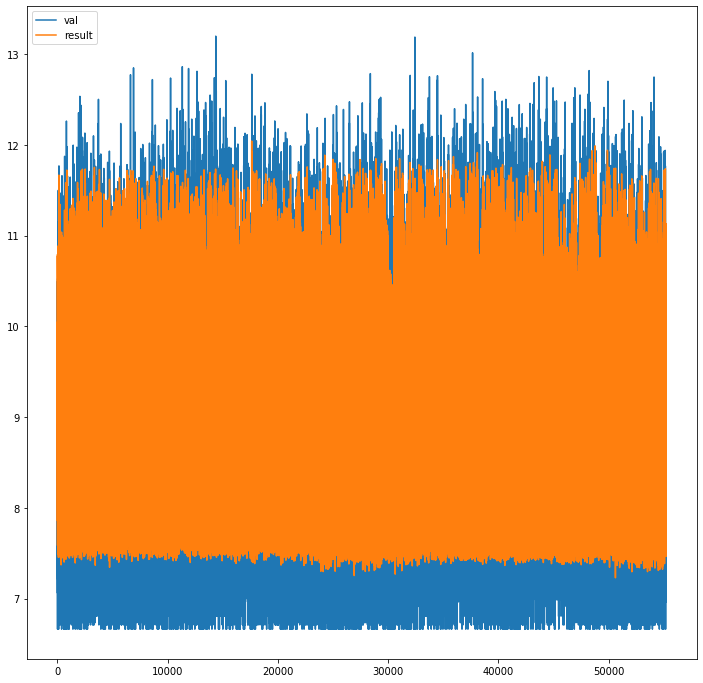

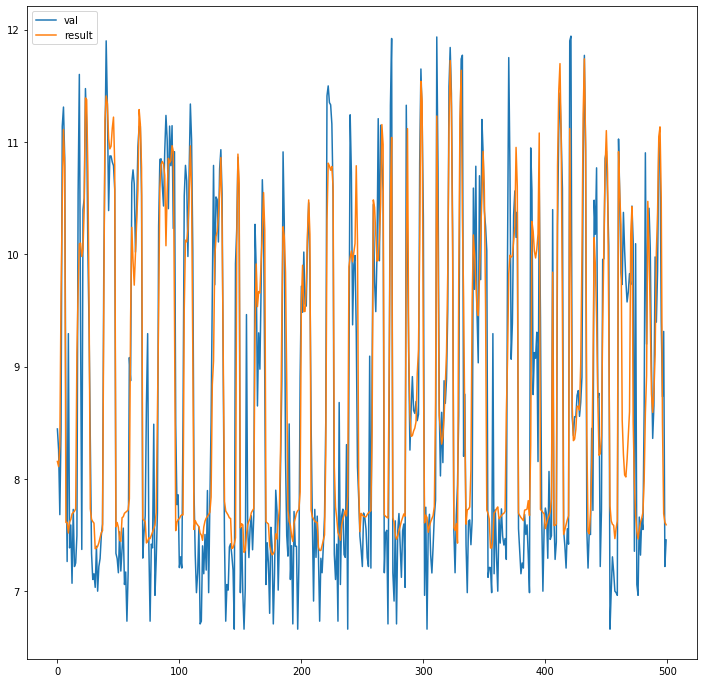

0.5877706938945003


In [43]:


results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.sum(results1[i,:])
    y[i] = np.sum(y_val_log[i,:])
    
plt.figure(figsize=(12,12))
plt.plot(y[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[:5000])
plt.plot(results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

mse_final = np.average((results-y)**2)
print(mse_final)

# Now try as an autual run senario where auroral type column is fully predicted (this is still in progress....)

(55210,) (55210, 149)
(55210, 149)


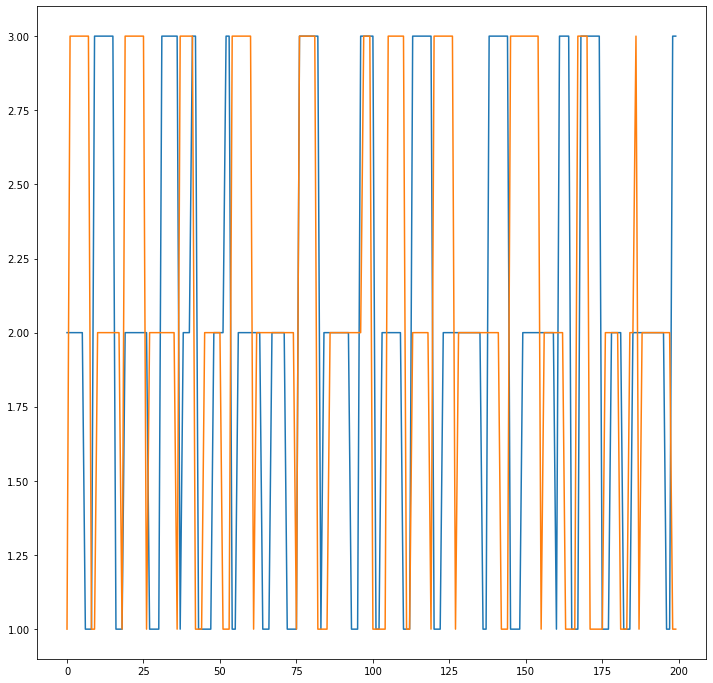

1726/1726 [==============================] - 1s 830us/step - loss: 31.2270 - mean_squared_error: 31.2270


[31.22696304321289, 31.22696304321289]

In [98]:
filename = 'best_auroral_region_predictor'

model2 = tensorflow.keras.models.load_model(filename)

feature_cols = [c for c in df_train.columns if not 'ELE' in c]
X_val = df_val[feature_cols].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_scaled = scaler_X.transform(X_val_no_aurora_type.values)

results = (model2.predict_classes(X_val_scaled))+1
print(results.shape, X_val.shape)



feature_cols = [c for c in df_train.columns if not 'ELE' in c]
X_val = df_val_new[feature_cols].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)

X_val_real_senario = X_val.copy(deep=True)
X_val_real_senario['aurora_type'] = results

print(X_val_real_senario.shape)
X_val_real_senario_scaled = scaler_X.transform(X_val_real_senario.values)

filename = 'best_with_auroral_region4_weighted'
model = tensorflow.keras.models.load_model(filename)

plt.figure(figsize=(12,12))
plt.plot(results[:200])
plt.plot(X_val['aurora_type'].values[:200])
plt.show()

model.evaluate(X_val_scaled,y_val_log)
model.evaluate(X_val_real_senario_scaled,y_val_log)

# Trying Multi-modal without auroral region type as input for X (This is working)
(but still using the auroal type to specify y_train and y_val for which of the three modes it is in)

In [99]:
feature_cols = [c for c in X_val.columns if not 'aurora_type' in c]
X_val = X_val[feature_cols].copy(deep=True)
X_train = X_train[feature_cols].copy(deep=True)

scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)


In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log),
                    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000, sample_weight=sample_weights)

In [ ]:
filename = 'best_modal__weighted'

model.save(filename)
# model.save_weights('my_model_weights2.h5')

model = tensorflow.keras.models.load_model(filename)

model.evaluate(X_val_scaled,y_val_log.values)

results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.max(results1[i,:])
    y[i] = np.max(y_val_log[i,:])

    

plt.figure(figsize=(12,12))
plt.plot(y[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

mse_final = np.average((results-y)**2)
print(mse_final)

In [ ]:

results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.sum(results1[i,:])
    y[i] = np.sum(y_val_log[i,:])

    

plt.figure(figsize=(12,12))
plt.plot(y[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

mse_final = np.average((results-y)**2)
print(mse_final)


In [ ]:
history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000)

In [ ]:

results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.sum(results1[i,:])
    y[i] = np.sum(y_val_log[i,:])

    

plt.figure(figsize=(12,12))
plt.plot(y[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

mse_final = np.average((results-y)**2)
print(mse_final)

In [ ]:
history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000)

In [ ]:

results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.sum(results1[i,:])
    y[i] = np.sum(y_val_log[i,:])

    

plt.figure(figsize=(12,12))
plt.plot(y[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

mse_final = np.average((results-y)**2)
print(mse_final)

In [ ]:
filename = 'best_auroral_region_predictor'

model2 = tensorflow.keras.models.load_model(filename)

results = (model2.predict_classes(X_val_no_aurora_type_scaled))+1

X_val_real_senario = np.array(X_val)
X_val_real_senario['aurora type'] = results
X_val_scaled_real_senario = scaler_X.transform(X_val_real_senario.values)

model.evaluate(X_val_scaled,y_val_log)
model.evaluate(X_val_scaled_real_senario,y_val_log)